In [414]:
import gc
from itertools import combinations
import os
import sys
import time
from typing import Optional
from unicodedata import bidirectional
from imblearn.over_sampling import SMOTE
import joblib
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras._tf_keras.keras.metrics import MeanAbsoluteError, Accuracy, Precision, Recall, MeanSquaredError
from keras._tf_keras.keras.models import Sequential
from keras._tf_keras.keras.optimizers import Adam , RMSprop, Nadam
from keras._tf_keras.keras.preprocessing.sequence import pad_sequences 
from keras._tf_keras.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Masking, InputLayer, Conv1D, MaxPooling1D, Flatten, TimeDistributed, LayerNormalization, Activation
from keras._tf_keras.keras.regularizers import L1L2, L1, L2
from keras._tf_keras.keras.utils import to_categorical
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
from scipy.stats import skew, kurtosis
import seaborn as sns
from sklearn.calibration import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.linear_model import Lasso
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from FeatureEngineering import FeatureEngineering as fe

In [47]:
def create_dataframe_from_data(input_path: str):
    dataframes = []

    for file_name in os.listdir(input_path):
        if file_name.endswith(".npy"):
            file_path = os.path.join(input_path, file_name)

            data = np.load(file_path, allow_pickle=True)
            df = pd.DataFrame(data)

            gesture = file_name.split("_")[0]
            gesture_index = int(file_name.split("_")[1].split(".")[0])
            df["gesture"] = gesture
            df["gesture_index"] = gesture_index

            dataframes.append(df)
            df.sort_values(by="frame", inplace=True)
    
    return pd.concat(dataframes, ignore_index=True) if len(dataframes) > 0 else ValueError("Dataframe has no data")

def split_dataset(dataframe: pd.DataFrame, target_label: str, additional_targets: list=None, train_ratio=0.8, test_ratio=0.2):
    
    assert train_ratio  + test_ratio == 1.0, "Ratios must sum to 1."
    
    train_frames = []
    test_frames = []

    for _, gesture_data in dataframe.groupby("gesture_index"):
        n_frames = len(gesture_data)
        n_train = int(n_frames * train_ratio)

        train_split = gesture_data.iloc[:n_train]
        test_split = gesture_data.iloc[n_train:]

        train_frames.append(train_split)
        test_frames.append(test_split)
    
    train_set = pd.concat(train_frames).reset_index(drop=True)
    test_set = pd.concat(test_frames).reset_index(drop=True)

    # Separate X and y
    X_train = train_set.drop(columns=[target_label])
    y_train = train_set[[target_label] + additional_targets]
    X_test = test_set.drop(columns=[target_label])
    y_test = test_set[[target_label] + additional_targets]

    return X_train, y_train, X_test, y_test




In [48]:
def calculate_hand_motion_features(df: pd.DataFrame, landmark_cols: list):
        
        df_copy = df.copy()

        s = time.process_time()
        df_elapsed = fe.calculate_elapsed_time(df_copy)    
        print(time.process_time()-s)
        s = time.process_time()
        df_temporal = fe.calculate_temporal_features(df_copy, landmark_cols)
        print(time.process_time()-s)
        # df_stats = fe.calculate_temporal_stats(df_copy, landmark_cols)
        # df_pairwise = fe.calculate_landmark_distances(df_copy, landmark_cols)
        # df_angle = fe.calculate_landmark_angles(df_copy, landmark_cols)
        # df_combined = pd.concat([df_copy, df_angle], axis=1)
        
        # Ensure there are no duplicate columns
        df_combined = df_copy.loc[:,~df_copy.columns.duplicated()]
        return df_combined


In [105]:
def reshape_y_labels(df: pd.DataFrame):
    """
    reasoning for this function:
    a single gesture recording can have the same index of n frames.
    This will balloon the size of the (x, y), when in reality it's much
    smaller. This will goo through each frame, and if the continuous pattern
    breaks (e.g. 12 -> 0), everything before "12" will be removed keeping only
    one instance of the gesture
    """
    unique_sequences = []
    for _, group in df.groupby("gesture_index"):
        reset_points = group['frame'].diff().fillna(1) < 0
        if reset_points.any():
            unique_sequences.append(group[reset_points])
        else:
            # If no reset points, consider the whole group as unique
            unique_sequences.append(group.iloc[[0]])

    # Concatenate unique sequences
    df_unique = pd.concat(unique_sequences).reset_index(drop=True)
    return df_unique["gesture"]

def encode_labels(y_train_reshaped, y_test_reshaped):
    label_encoder = LabelEncoder()
    combined_labels = pd.concat([y_train_reshaped, y_test_reshaped])
    label_encoder.fit_transform(combined_labels)

    y_train_encoded = label_encoder.fit_transform(y_train_reshaped)
    y_test_encoded = label_encoder.fit_transform(y_test_reshaped)

    return label_encoder,y_train_encoded, y_test_encoded

def find_longest_continuous_chain(df: pd.DataFrame):
    gesture_index_cols = df.columns[df.columns.str.startswith("cat__gesture_index_")]

    longest_length = 0 
    target_gesture_index = None 

    for col in gesture_index_cols:
        gesture_index = col.split("_")[-1]
        gesture_data = df[col].values 

        # Use NumPy to find the lengths of continuous sequences of 1s
        padded = np.pad(gesture_data, (1, 1), constant_values=0)
        diff = np.diff(padded)
        start_indices = np.where(diff == 1)[0]
        end_indices = np.where(diff == -1)[0]
        lengths = end_indices - start_indices
        
        max_length = lengths.max() if lengths.size > 0 else 0

        if max_length > longest_length:
            longest_length = max_length
            target_gesture_index = gesture_index

    return [longest_length, target_gesture_index]

def pad_dataframe(df: pd.DataFrame, train_pad_len = None):

    frame_list = find_longest_continuous_chain(df.copy())

    cols_to_pad = [col for col in df.columns if col.startswith("cat__gesture_index_") and col != frame_list[1]]
    num_of_cols = [col for col in df.columns if col.startswith("cat__gesture_index_")]

    if train_pad_len is not None:
        frame_list[0] = train_pad_len 
        cols_to_pad = [col for col in df.columns if col.startswith("cat__gesture_index_")]
        num_of_cols = [col for col in df.columns if col.startswith("cat__gesture_index_")]

    columns = df.columns
    data = df.values 
    for col in cols_to_pad:
        col_index = df.columns.get_loc(col)
        num_frames = int(df[col].sum())
        frames_diff = frame_list[0] - num_frames

        if frames_diff > 0: 
            gesture_index_rows = np.where(data[:, col_index] == 1)[0]
            last_frame_index = gesture_index_rows[-1]
            
            # Create padding array with -1 values for all columns except the current col
            padding_data = np.full((frames_diff, data.shape[1]), -1)
            padding_data[:, col_index] = -1
            
            # Insert padding rows after the last frame of the current gesture
            data = np.insert(data, last_frame_index + 1, padding_data, axis=0)

    # Convert the NumPy array back to a DataFrame
    padded_df = pd.DataFrame(data, columns=columns).drop(columns=num_of_cols)

    # padded_df.to_csv(f"model/LSTM/v2/{time.time()}.csv", index=False)
    # return numpy arrary, number of samples, timesteps, features
    return padded_df.to_numpy(), len(num_of_cols), frame_list[0], len(padded_df.columns.values.tolist())

In [50]:
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer


def preprocess_pipeline(timeseries_columns, numerical_columns, categorical_columns):
    ts_numerical_transformer = Pipeline(steps=[
        ('imputer', KNNImputer(n_neighbors=5)), # might want to change this out back to the interpolatioon methods
        ('imputer2', SimpleImputer(strategy="mean")),
        ('scaler', MinMaxScaler())
        # ('smoother', FunctionTransformer(lambda x: x.rolling(window=3, min_periods=1).mean())),
        # ('differencing', FunctionTransformer(lambda x: x.diff().fillna(0))),
        # ('lag_features', FunctionTransformer(lambda x: pd.concat([x.shift(i) for i in range(1, 4)], axis=1).fillna(0))),
        # ('rolling_stats', FunctionTransformer(lambda x: pd.concat([x.rolling(window=3).mean(), x.rolling(window=3).std()], axis=1).fillna(0)))
    ])

    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="mean")),
        # ('poly', PolynomialFeatures(degree=2, include_bias=False)),  # Polynomial features
        # ('power', PowerTransformer(method='yeo-johnson')),   
        ("normalize", StandardScaler()),
        ('pca', PCA(n_components=10))
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy="most_frequent")), # technically this is wrong
        ("ohe", OneHotEncoder(sparse_output=False))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('ts_num', ts_numerical_transformer, timeseries_columns),
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ],
        remainder='passthrough',
        sparse_threshold=0,
        n_jobs=-1
    )
 
    preprocessor.set_output(transform="pandas")
    
    return preprocessor

In [433]:
def create_lstm(input_shape, output_units):
    print(input_shape)

    activate = "softmax"
    loss_type = "categorical_crossentropy"
    if len(output_units) == 1:
        activate = "sigmoid"
        loss_type = "binary_crossentropy"

    model = Sequential()
# model is good here
    model.add(InputLayer(shape=(input_shape[1], input_shape[2])))
    model.add(Masking(mask_value=-1))
    model.add(LSTM(96, kernel_regularizer=L2(1e-4), bias_regularizer=L1(1e-5), return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(32, return_sequences=True, kernel_regularizer=L2(1e-5)))
    model.add(LayerNormalization())
    model.add(Bidirectional(LSTM(48, return_sequences=True, kernel_regularizer=L2(1e-3))))
    model.add(LayerNormalization())
    model.add(LSTM(32, kernel_regularizer=L2(1e-3)))
    model.add(Dense(64))
    model.add(Activation("tanh"))
    model.add(Dropout(0.4))
    model.add(Dense(units=len(np.unique(output_units)), activation=activate,  kernel_regularizer=L2(0.00001), bias_regularizer=L2(0.0001)))

    # model.add(LSTM(64, return_sequences=True, activation="relu", input_shape=input[1:], kernel_regularizer=L1L2(l1=1e-5, l2=1e-4), bias_regularizer=L2(0.001)))
    # model.add(Dense(64, activation="relu"))
    # model.add(Dropout(0.2))
    # model.add(LSTM(24, activation="relu"))
    # model.add(Dropout(0.2))
    # model.add(Dense(units=len(np.unique(output_units)), activation=activate,  kernel_regularizer=L1L2(0.00001), bias_regularizer=L2(0.0001)))
    
    model.compile(optimizer=Adam(learning_rate=1e-4, clipnorm=1.0), loss=loss_type, metrics=['accuracy'])
    model.summary()
    return model

# observations: learning rate in adam - just don't adjust

In [171]:
input_dir = "C:\\Users\Gen3r\Documents\\capstone\\ml_model\\data\\data_3"
dataframe = create_dataframe_from_data(input_dir)

landmark_columns = [f"{col}" for col in dataframe.columns if col.startswith(("hx", "hy", "hz", "px", "py", "pz", "lx", "ly", "lz", "rx", "ry", "rz"))]
categorical_columns = ["gesture_index"]
numerical_columns = ["frame", "frame_rate", "frame_width", "frame_height"] + [f"{col}" for col in dataframe.columns if col.startswith("pose_visibility")]
derived_features =  ['elapsed_time'] + \
                    [f"{feat}_{col}" for feat in ["velocity", "acceleration", "jerk"] for col in landmark_columns if col.startswith(("lx", "ly", "lz", "rx", "ry", "rz"))]
time_series_columns = landmark_columns + derived_features            

In [54]:
# NOTE: find way to shiffle the time series so that some of the recordings later on appear first
X_train, y_train, X_test, y_test = split_dataset(dataframe, "gesture", ["frame", "gesture_index"])
res = [item for item in landmark_columns if item.startswith(("r", "l"))]
# feature engineering takes too long
X_train_fe = calculate_hand_motion_features(X_train, res)
X_test_fe = calculate_hand_motion_features(X_test, res)



0.0
3.21875
0.015625
3.390625


In [ ]:

preprocessor = preprocess_pipeline(time_series_columns, numerical_columns, categorical_columns)
X_train_transformed = preprocessor.fit_transform(X_train_fe)
X_test_transformed = preprocessor.transform(X_test_fe)

y_train_reshaped = reshape_y_labels(y_train)
y_test_reshaped = reshape_y_labels(y_test)

y_train_encoded, labels = pd.factorize(y_train_reshaped)
y_test_encoded, _ = pd.factorize(y_test_reshaped)
class_labels = labels

y_train_one_hot = to_categorical(y_train_encoded, num_classes=len(labels))
y_test_one_hot = to_categorical(y_test_encoded, num_classes=len(labels))

X_train_padded, batch_size1, steps_len1, num_features = pad_dataframe(X_train_transformed)
X_test_padded, batch_size3, steps_len3, num_features3 = pad_dataframe(X_test_transformed)

X_train_reshaped = np.reshape(X_train_padded, (batch_size1, steps_len1, num_features))
X_test_reshaped = np.reshape(X_test_padded, (batch_size3, steps_len3, num_features3))

print("before lstm:",X_train_reshaped.shape, X_test_reshaped.shape, y_train_one_hot.shape, y_test_one_hot.shape)

before lstm: (68, 24, 2018) (68, 6, 2018) (68, 2) (68, 2)


(68, 24, 2018)


Model: "sequential_194"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_193 (Masking)           │ (None, 24, 2018)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_433 (LSTM)                 │ (None, 24, 96)         │       812,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_220 (Dropout)           │ (None, 24, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_434 (LSTM)                 │ (None, 24, 32)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_75          │ (None, 24, 32)         │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_94                │ (None, 24, 96)         │        31,104 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_76          │ (None, 24, 96)         │           192 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_436 (LSTM)                 │ (None, 32)             │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_335 (Dense)               │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_221 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_336 (Dense)               │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 878,786 (3.35 MB)

 Trainable params: 878,786 (3.35 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
2/2 - 14s - 7s/step - accuracy: 0.5741 - loss: 0.9223 - val_accuracy: 0.4286 - val_loss: 1.0356 - learning_rate: 1.0000e-04
Epoch 2/200
2/2 - 0s - 110ms/step - accuracy: 0.7963 - loss: 0.7857 - val_accuracy: 0.8571 - val_loss: 0.9039 - learning_rate: 1.0000e-04
Epoch 3/200
2/2 - 0s - 106ms/step - accuracy: 0.8704 - loss: 0.7535 - val_accuracy: 1.0000 - val_loss: 0.7648 - learning_rate: 1.0000e-04
Epoch 4/200
2/2 - 0s - 109ms/step - accuracy: 0.9259 - loss: 0.6450 - val_accuracy: 1.0000 - val_loss: 0.6954 - learning_rate: 1.0000e-04
Epoch 5/200
2/2 - 0s - 106ms/step - accuracy: 0.9630 - loss: 0.5906 - val_accuracy: 1.0000 - val_loss: 0.6326 - learning_rate: 1.0000e-04
Epoch 6/200
2/2 - 0s - 100ms/step - accuracy: 0.9815 - loss: 0.5716 - val_accuracy: 1.0000 - val_loss: 0.5781 - learning_rate: 1.0000e-04
Epoch 7/200
2/2 - 0s - 103ms/step - accuracy: 0.9815 - loss: 0.5773 - val_accuracy: 1.0000 - val_loss: 0.5214 - learning_rate: 1.0000e-04
Epoch 8/200
2/2 - 0s - 101ms/step - 

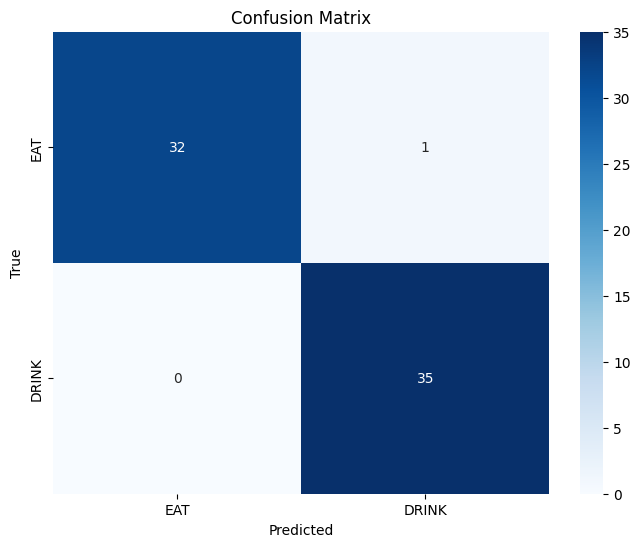

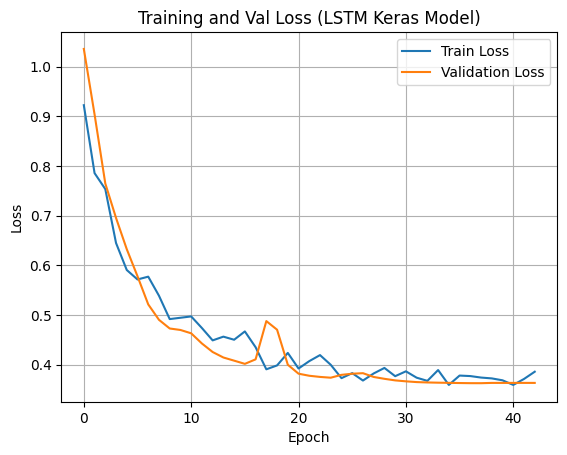

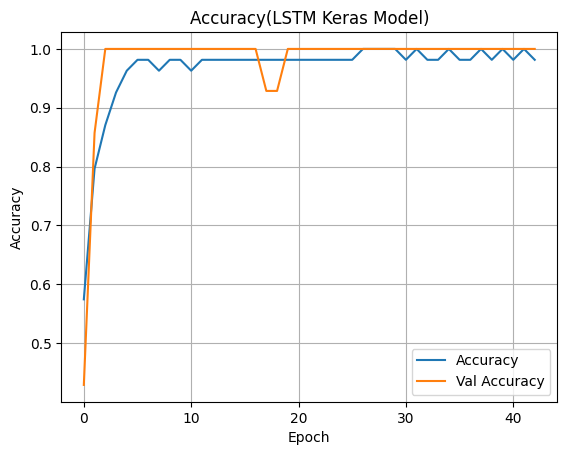

In [434]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)	
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-10)	
model_checkpoint = ModelCheckpoint(filepath=f"checkpoints/checkpoint{time.time()}.model.keras", mode="max", monitor="val_accuracy", save_best_only=True)

input = (X_train_reshaped.shape[0], X_train_reshaped.shape[1], X_train_reshaped.shape[2])
model = create_lstm(input, labels)

# if os.path.exists("checkpoints/checkpoint.model.keras"):
#     model.build(input_shape=(None, X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
#     model.load_weights("checkpoints/checkpoint.model.keras")

history = model.fit(
    X_train_reshaped, y_train_one_hot, 
    epochs=200,  
    validation_split=0.20,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test_reshaped, y_test_one_hot)	
print(f'Test Accuracy: {test_acc} || Test Loss: {test_loss}')

y_pred = model.predict(X_test_reshaped)
y_test_labels = np.argmax(y_test_one_hot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)
labels = np.unique(np.concatenate((y_test_labels, y_pred_labels)))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=labels)
print("labels:", class_labels)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.ion()
plt.show()

# Extracting the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc= history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)
epochs = range(len(train_loss))  # Assuming loss recorded for each epoch

# Plotting
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')

plt.title('Training and Val Loss (LSTM Keras Model)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.plot(epochs, train_acc, label='Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.title('Accuracy(LSTM Keras Model)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save("decentmodelv3.keras")